In [1]:
import zarr
import xarray as xr
import matplotlib.pyplot as plt
import gzip
import pickle
import numpy as np

In [ ]:
with gzip.open('/home/scratch/Abel_data/obs_mask10', 'rb') as f:
    obs_mask = pickle.load(f)

T=[]
common=xr.open_zarr("/home/scratch/Abel_data/long_run2/common",consolidated=False)
lat=np.radians(common['latitude'])

c=0
Dy_array=0
for i in range(1,26):
    print(i)
    for j in range(1,21):
        
        D=xr.open_zarr("/home/scratch/Abel_data/long_run2/run"+str(i)+"/year"+str(j),consolidated=False)

        if c==0:
            Dy_array=(D.mean(dim='time')).expand_dims(time=[c])
            c=c+1
        else:
            Dy_array=xr.combine_by_coords([Dy_array,(D.mean(dim='time')).expand_dims(time=[c])])
            c=c+1
            
        del D
            
print(Dy_array)
Dy_mean=Dy_array.mean(dim='time')

del Dy_array

print(Dy_mean)

store = zarr.storage.DirectoryStore("/home/scratch/Abel_data/climatology_500c") 
(Dy_mean).to_zarr(store=store, mode='w')

In [ ]:
with gzip.open('/home/scratch/Abel_data/obs_mask10', 'rb') as f:
    obs_mask = pickle.load(f)

T=[]
common=xr.open_zarr("/home/scratch/Abel_data/long_run2/common",consolidated=False)
lat=np.radians(common['latitude'])

c=0
Dy_array=0
for i in range(26,51):
    print(i)
    for j in range(1,21):
        
        D=xr.open_zarr("/home/scratch/Abel_data/long_run2/run"+str(i)+"/year"+str(j),consolidated=False)

        if c==0:
            Dy_array=(D.mean(dim='time')).expand_dims(time=[c])
            c=c+1
        else:
            Dy_array=xr.combine_by_coords([Dy_array,(D.mean(dim='time')).expand_dims(time=[c])])
            c=c+1
            
        del D
            
print(Dy_array)
Dy_mean=Dy_array.mean(dim='time')

del Dy_array

print(Dy_mean)

store = zarr.storage.DirectoryStore("/home/scratch/Abel_data/climatology_500d") 
(Dy_mean).to_zarr(store=store, mode='w')

<IPython.core.display.Javascript object>


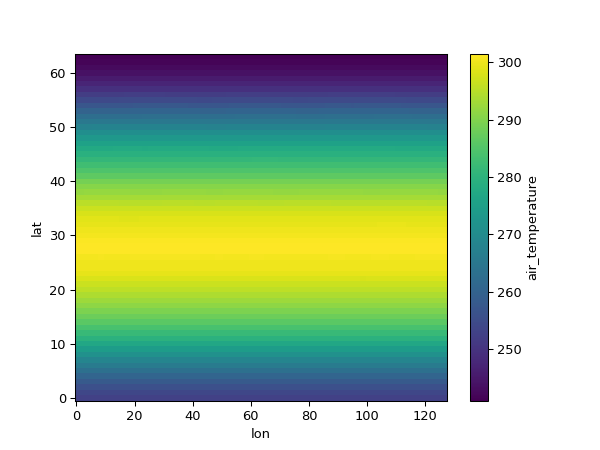

In [5]:
%matplotlib notebook
clima=xr.open_zarr("/home/scratch/Abel_data/climatology_500c",consolidated=False)
climb=xr.open_zarr("/home/scratch/Abel_data/climatology_500d",consolidated=False)

clim=xr.combine_by_coords([clima.expand_dims(time=[0]), climb.expand_dims(time=[1])])
clim=clim.mean(dim='time')

clim['air_temperature'][0].plot()

store = zarr.storage.DirectoryStore("/home/scratch/Abel_data/climatology_1000") 
(clim).to_zarr(store=store, mode='w')

In [2]:
# %matplotlib notebook
from sympl import get_constant
from scipy import interpolate

Rd = get_constant('gas_constant_of_dry_air', 'J kg^-1 K^-1')
Cp =\
    get_constant('heat_capacity_of_dry_air_at_constant_pressure',
                 'J kg^-1 K^-1')
g=get_constant('gravitational_acceleration',
                 'm s^-2') 

Lv=2260000

lat1=16
lat2=22
lon1=35
lon2=41

common=xr.open_zarr("/home/scratch/Abel_data/long_run2/common",consolidated=False)
lat_rad=np.radians(common['latitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]
lon_rad=np.radians(common['longitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]

lat_deg=(common['latitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]
lon_deg=(common['longitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]

print(lat_deg[0,0],lat_deg[-1,0])
print(lon_deg[0,-1],lon_deg[0,0])
lat_diff=lat_deg[0,0]-lat_deg[1,0]
lon_diff=lon_deg[0,1]-lon_deg[0,0]

Lx=np.radians(lon_diff)*6371*1000
Ly=np.radians(lat_diff)*6371*1000

p_std = np.arange(0.1, 9.9 ,0.2)[::-1]*10000

def interpol1d(X, p):
    
    h,lt,ln=np.shape(p)
    out=np.zeros((len(p_std),lt,ln))
    
    for i in range(lt):
        for j in range(ln):
            f = interpolate.interp1d(p[:,i,j], X[:,i,j])
            out[:,i,j]=f(p_std)
            
    return out

clim=xr.open_zarr("/home/scratch/Abel_data/climatology_1000",consolidated=False)
temp=clim['air_temperature'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
uwind=clim['eastward_wind'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
nwind=clim['northward_wind'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
press=clim['air_pressure'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
spress=clim['surface_air_pressure'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
sens=clim['surface_upward_sensible_heat_flux'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
latent=clim['surface_upward_latent_heat_flux'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))

uwind=interpol1d(uwind, press)
nwind=interpol1d(nwind, press)
temp=interpol1d(temp, press)

rho=(p_std[:,np.newaxis,np.newaxis]/(Rd*temp))[:,1:-1,1:-1]

press_int=np.insert(p_std, 0, 101300)       

# dz calculation

dp=(press_int[:-1]-press_int[1:])

dz=Rd*temp/g*np.log(press_int[:-1]/press_int[1:])[:,np.newaxis,np.newaxis]
z=dz.cumsum(axis=0)

dse=Cp*temp+g*z
geo=g*z
print(geo[33].mean())

dudx=(uwind[:,1:-1,2:]-uwind[:,1:-1,:-2])/((lon_rad[1:-1,2:]-lon_rad[1:-1,:-2])*6371*1000*np.cos(lat_rad[1:-1,1:-1]))
dvdy=(nwind[:,2:,1:-1]*np.cos(lat_rad[2:,1:-1])-nwind[:,:-2,1:-1]*np.cos(lat_rad[:-2,1:-1]))/((lat_rad[2:,1:-1]-lat_rad[:-2,1:-1])*6371*1000*np.cos(lat_rad[1:-1,1:-1]))

dwdp=-(dudx+dvdy)
w=np.cumsum(dwdp*-dp[:,np.newaxis,np.newaxis],axis=0)

windxmean=(uwind[:,1:-1,1:-1])
DSExmean=((dse[:,1:-1,2:]-dse[:,1:-1,:-2])/((lon_rad[1:-1,2:]-lon_rad[1:-1,:-2])*6371*1000*np.cos(lat_rad[1:-1,1:-1])))
windymean=(nwind[:,1:-1,1:-1])
DSEymean=((dse[:,2:,1:-1]-dse[:,:-2,1:-1])/((lat_rad[2:,1:-1]-lat_rad[:-2,1:-1])*6371*1000))
print(DSEymean[0])

windzmean=(w)
dsez=DSEymean.copy()
dsez[1:]=(dse[1:,1:-1,1:-1]-dse[:-1,1:-1,1:-1])/(-dp[1:,np.newaxis,np.newaxis])
dsez[0]=(dse[1,1:-1,1:-1]-dse[0,1:-1,1:-1])/(-dp[1])
DSEzmean=(dsez)

meanx=-(DSExmean*windxmean*dp[:,np.newaxis,np.newaxis]/g*np.cos(lat_rad[1:-1,1:-1])*Lx*Ly*86400)[:7,:,:].sum(axis=(0,1,2))
meany=-(DSEymean*windymean*dp[:,np.newaxis,np.newaxis]/g*np.cos(lat_rad[1:-1,1:-1])*Lx*Ly*86400)[:7,:,:].sum(axis=(0,1,2))
meanz=-(DSEzmean*windzmean*dp[:,np.newaxis,np.newaxis]/g*np.cos(lat_rad[1:-1,1:-1])*Lx*Ly*86400)[:7,:,:].sum(axis=(0,1,2))

print(meany,meanz)
with gzip.open('/home/scratch/Abel_data/advection_meanv2', 'wb') as f:
    pickle.dump([DSExmean, DSEymean, DSEzmean, windxmean, windymean, windzmean], f)

/home/data/miniconda3/lib/python3.8/site-packages/sympl/_core/dataarray.py:6: FutureWarning: xarray subclass DataArray should explicitly define __slots__
  class DataArray(xr.DataArray):


43.25419466535094 29.301359621762735
112.5 98.4375
89439.71114469372
[[-0.0048182  -0.00481593 -0.00481087 -0.0048072 ]
 [-0.00474402 -0.00473703 -0.00473127 -0.00473024]
 [-0.00479482 -0.00478872 -0.00478666 -0.00478755]
 [-0.00446435 -0.00446445 -0.00446776 -0.00446873]]
-1.4030920568281747e+17 5.2422613240468424e+16


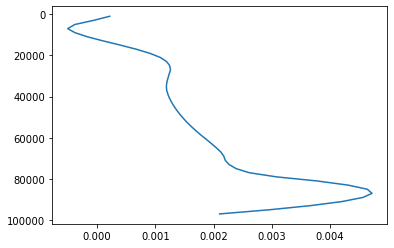

In [7]:
p_std = np.arange(0.1, 9.9 ,0.2)[::-1]*10000

with gzip.open('/home/scratch/Abel_data/advection_meanv1', 'rb') as f:
    DSExmean, DSEymean, DSEzmean, windxmean, windymean, windzmean=pickle.load(f)
    
plt.plot(windzmean.mean(axis=(1,2)),p_std)
plt.gca().invert_yaxis()

51.62573367493825 26.510769325210994
112.5 98.4375


<IPython.core.display.Javascript object>


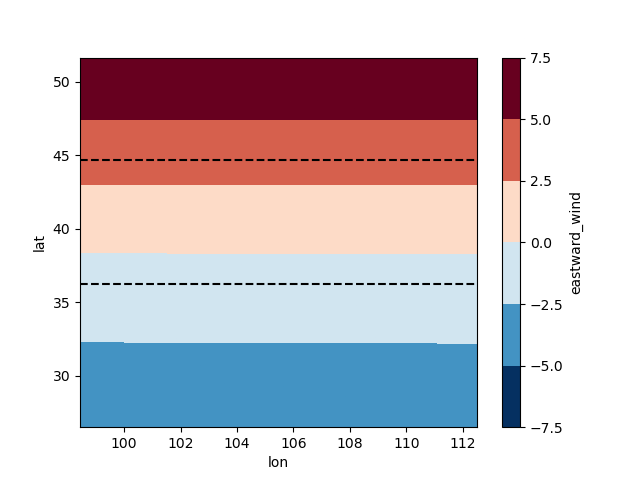

In [16]:
%matplotlib notebook
from sympl import get_constant
from scipy import interpolate

Rd = get_constant('gas_constant_of_dry_air', 'J kg^-1 K^-1')
Cp =\
    get_constant('heat_capacity_of_dry_air_at_constant_pressure',
                 'J kg^-1 K^-1')
g=get_constant('gravitational_acceleration',
                 'm s^-2') 

Lv=2260000

lat1=13
lat2=23
lon1=35
lon2=41

common=xr.open_zarr("/home/scratch/Abel_data/long_run2/common",consolidated=False)
lat_rad=np.radians(common['latitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]
lon_rad=np.radians(common['longitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]

lat_deg=(common['latitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]
lon_deg=(common['longitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]

print(lat_deg[0,0],lat_deg[-1,0])
print(lon_deg[0,-1],lon_deg[0,0])
lat_diff=lat_deg[0,0]-lat_deg[1,0]
lon_diff=lon_deg[0,1]-lon_deg[0,0]

Lx=np.radians(lon_diff)*6371*1000
Ly=np.radians(lat_diff)*6371*1000

p_std = np.arange(0.1, 9.9 ,0.2)[::-1]*10000

clim=xr.open_zarr("/home/scratch/Abel_data/climatology_1000",consolidated=False)
temp=clim['air_temperature'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
uwind=clim['eastward_wind'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
nwind=clim['northward_wind'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
press=clim['air_pressure'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
spress=clim['surface_air_pressure'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
sens=clim['surface_upward_sensible_heat_flux'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
latent=clim['surface_upward_latent_heat_flux'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))

D=xr.DataArray(data=uwind[0], dims=["lat", "lon"])
D=D.assign_coords(lat=lat_deg[:,0],lon=lon_deg[0,:])
D.plot.contourf()
plt.axhline(44.7,linestyle='dashed',color='black')
plt.axhline(36.27,linestyle='dashed',color='black')